# **Построение модели**

В качестве baseline модели для решения задачи классификации мы используем `Logistic regression`. После чего попробуем использовать `KNN`, `Random forest`, `GBM` из библиотеки `xgboost`. Подберем гипперпараметры для данных моделей. Также сделаем отбор признаков в датасете, посмотрим как улучшится качество. Также можно выделить признаки с помощью `PCA`. Будем пытаться улучшить модели по метрике `AUC-ROC`.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import roc_auc_score, classification_report, f1_score

warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
credit_score_df = pd.read_csv("~/Documents/datasets/transformed_credit_score.csv")

credit_score_df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0000,...,_,809.98,26.822620,265.0000,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,True
1,23.0,Scientist,19114.12,4194.150202,3.0,4.0,3.0,4.0,-1.0,30.9254,...,Good,809.98,31.944960,221.1933,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,True
2,33.0,Scientist,19114.12,4194.150202,3.0,4.0,3.0,4.0,3.0,7.0000,...,Good,809.98,28.609352,267.0000,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,True
3,23.0,Scientist,19114.12,4194.150202,3.0,4.0,3.0,4.0,5.0,4.0000,...,Good,809.98,31.377862,268.0000,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,True
4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,30.9254,...,Good,809.98,24.797347,269.0000,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,True


In [6]:
#Выделим целевую переменную 
X = credit_score_df.drop(columns = ['Credit_Score'])
y = credit_score_df['Credit_Score']

X = pd.get_dummies(X, drop_first=True)

In [7]:
#Разделим выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True, random_state = 42)

In [8]:
X_train.shape, X_test.shape

((79992, 43), (19999, 43))

In [9]:
#Нормализуем данные с помощью StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

Построим `baseline` модель в виде `LogisticRegression`, подберём оптимальные гипперпараметры, после чего будем сравнивать улучшилась ли метрика `AUC-ROC` при построении более сложных моделей.

In [11]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()

logistic_model.fit(X_train_std, y_train)

print(f"AUC ROC score for logistic regression on train: {roc_auc_score(y_train, logistic_model.predict(X_train_std)):.3f}")
print(f"AUC ROC score for logistic regression on test: {roc_auc_score(y_test, logistic_model.predict(X_test_std)):.3f}")

AUC ROC score for logistic regression on train: 0.663
AUC ROC score for logistic regression on test: 0.657


Модель уже неплохо разделяет выборку, `AUC-ROC` на тестовых данных сопоставим с значением на тренировочной, значит модель не переобучается на наших данных.

Теперь подберем оптимальне гипперпараметры для логистической регресси с помощью `GridSearchCV`.

In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid_search1 = GridSearchCV(estimator=logistic_model, 
                            param_grid=param_grid, 
                            cv=5, 
                            scoring='roc_auc',
                            verbose = 1)

grid_search1.fit(X_train_std, y_train)

print(f"Best Parameters: {grid_search1.best_params_}")
print(f"Best Score: {grid_search1.best_score_:.3f}")
print(f"Test Score: {grid_search1.score(X_test_std, y_test):.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.785
Test Score: 0.785


Зафиксируем лучшие гипперпараметры для `LogisticRegression`, посмотрим как изменился `AUC-ROC` на тестовой выборке, также выведем `classification_report`.

In [15]:
from sklearn.linear_model import LogisticRegression

best_logistic_model = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear')

best_logistic_model.fit(X_train_std, y_train)

print(f"AUC ROC score for logistic regression on test: {roc_auc_score(y_test, best_logistic_model.predict(X_test_std)):.3f}")
print(f"Classification report:\n {classification_report(y_test, best_logistic_model.predict(X_test_std))}")

AUC ROC score for logistic regression on test: 0.658
Classification report:
               precision    recall  f1-score   support

       False       0.64      0.41      0.50      5800
        True       0.79      0.91      0.84     14199

    accuracy                           0.76     19999
   macro avg       0.71      0.66      0.67     19999
weighted avg       0.75      0.76      0.74     19999



Как мы видем `AUC-ROC` практически не изменился, подбор параметров не сильно повлиял на модель. Проведем кросс-валидацию для нашей `baseline` модели, далее будем пытаться улучшать это значение с помощью других моделей.

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

pipeline = make_pipeline(StandardScaler(), 
                         best_logistic_model)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc')

print(f"Mean AUC-ROC with cross validation on logistic regression: {np.mean(scores):.3f}")

Mean AUC-ROC with cross validation on logistic regression: 0.784


После того как мы получили среднее значение `AUC-ROC` для нашей `baseline` модели, будем пытаться улучшить данное значение с помощью других моделей: `RandomForestClassifier`, `KNeighborsClassifier`, `XGBClassifier`.

Обучим модель `RandomForestClassifier`, подберем гипперпараметры.

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_model.fit(X_train_std, y_train)

print(f"AUC ROC score for random forest on train: {roc_auc_score(y_train, rf_model.predict(X_train_std)):.3f}")
print(f"AUC ROC score for random forest on test: {roc_auc_score(y_test, rf_model.predict(X_test_std)):.3f}")

AUC ROC score for random forest on train: 1.000
AUC ROC score for random forest on test: 0.843


Теперь подберем гипперпараметры для случайного леса с помощью `RandomizedSearch`.

In [22]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rand_search1 = RandomizedSearchCV(estimator=rf_model, 
                                  param_distributions=param_dist, 
                                  cv=3,
                                  n_iter=30,
                                  scoring='roc_auc', 
                                  verbose = 1,
                                  random_state = 42)

rand_search1.fit(X_train_std, y_train)

print(f"Best Parameters: {rand_search1.best_params_}")
print(f"Best Score: {rand_search1.best_score_:.3f}")
print(f"Test Score: {rand_search1.score(X_test_std, y_test):.3f}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}
Best Score: 0.915
Test Score: 0.930


In [66]:
from sklearn.ensemble import RandomForestClassifier

best_rf_model = RandomForestClassifier(n_estimators = 100, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 'sqrt', 
                                       max_depth = 50)

best_rf_model.fit(X_train_std, y_train)

print(f"AUC ROC score for best random forest on test: {roc_auc_score(y_test, best_rf_model.predict(X_test_std)):.2f}")
print(f"Classification report:\n {classification_report(y_test, best_rf_model.predict(X_test_std))}")

AUC ROC score for best random forest on test: 0.84
Classification report:
               precision    recall  f1-score   support

       False       0.79      0.76      0.78      5800
        True       0.90      0.92      0.91     14199

    accuracy                           0.87     19999
   macro avg       0.85      0.84      0.84     19999
weighted avg       0.87      0.87      0.87     19999



Посчитаем среднее значение метрики на кросс-валидации для случайного леса.

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

pipeline = make_pipeline(StandardScaler(), 
                         best_rf_model)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc')

print(f"Mean AUC-ROC with cross validation on random forest: {np.mean(scores):.3f}")

Mean AUC-ROC with cross validation on random forest: 0.926


Обучим модель `KNeighborsClassifier`, подберем гипперпараметры.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 5)

knn_model.fit(X_train_std, y_train)

print(f"AUC ROC score for KNN on train: {roc_auc_score(y_train, knn_model.predict(X_train_std)):.3f}")
print(f"AUC ROC score for KNN on test: {roc_auc_score(y_test, knn_model.predict(X_test_std)):.3f}")

AUC ROC score for KNN on train: 0.774
AUC ROC score for KNN on test: 0.690


Теперь подберем гипперпараметры для `KNN` с помощью `RandomizedSearch`.

In [29]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

rand_search2 = RandomizedSearchCV(estimator=knn_model, 
                                  param_distributions=param_dist, 
                                  cv=3,
                                  n_iter=20,
                                  scoring='roc_auc', 
                                  verbose = 1,
                                  random_state = 42)


rand_search2.fit(X_train_std, y_train)

print(f"Best Parameters: {rand_search2.best_params_}")
print(f"Best Score: {rand_search2.best_score_:.3f}")
print(f"Test Score: {rand_search2.score(X_test_std, y_test):.3f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}
Best Score: 0.809
Test Score: 0.826


In [30]:
from sklearn.neighbors import KNeighborsClassifier

best_knn_model = KNeighborsClassifier(weights = 'distance', 
                                      n_neighbors = 9, 
                                      metric = 'manhattan')

best_knn_model.fit(X_train_std, y_train)

print(f"AUC ROC score for best KNN on test: {roc_auc_score(y_test, best_knn_model.predict(X_test_std)):.3f}")
print(f"Classification report:\n {classification_report(y_test, best_knn_model.predict(X_test_std))}")

AUC ROC score for best KNN on test: 0.720
Classification report:
               precision    recall  f1-score   support

       False       0.70      0.53      0.61      5800
        True       0.83      0.91      0.86     14199

    accuracy                           0.80     19999
   macro avg       0.76      0.72      0.74     19999
weighted avg       0.79      0.80      0.79     19999



Посчитаем среднее значение метрики на кросс-валидации для `KNN`.

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

pipeline = make_pipeline(StandardScaler(), 
                         best_knn_model)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc')

print(f"Mean AUC-ROC with cross validation on KNN: {np.mean(scores):.3f}")

Mean AUC-ROC with cross validation on KNN: 0.820


Теперь обучим `XGBClassifier` из библиотеки `xgboost`, попробуем подобрать гипперапараметры так, чтобы обогнать модель случайного леса.

In [34]:
from xgboost import XGBClassifier

gb_model = XGBClassifier()

gb_model.fit(X_train_std, y_train)

print(f"AUC ROC score for gradient boosting on train: {roc_auc_score(y_train, gb_model.predict(X_train_std)):.2f}")
print(f"F1 score for gradient boosting on train: {f1_score(y_train, gb_model.predict(X_train_std)):.2f}\n")
print(f"AUC ROC score for gradient boosting on test: {roc_auc_score(y_test, gb_model.predict(X_test_std)):.2f}")
print(f"F1 score for gradient boosting on test: {f1_score(y_test, gb_model.predict(X_test_std)):.2f}")

AUC ROC score for gradient boosting on train: 0.86
F1 score for gradient boosting on train: 0.92

AUC ROC score for gradient boosting on test: 0.81
F1 score for gradient boosting on test: 0.90


In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

gb_param_dist = {
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 11),
    'min_child_weight': randint(1, 11),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 1),
    'n_estimators': randint(50, 1001)
    }

rand_search3 = RandomizedSearchCV(estimator=gb_model, 
                                  param_distributions=gb_param_dist, 
                                  cv=5,
                                  n_iter=150,
                                  scoring='roc_auc', 
                                  verbose = 1,
                                  random_state = 42)


rand_search3.fit(X_train_std, y_train)

print(f"Best Parameters: {rand_search3.best_params_}")
print(f"Best Score: {rand_search3.best_score_:.3f}")
print(f"Test Score: {rand_search3.score(X_test_std, y_test):.3f}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'colsample_bytree': 0.6066351315711425, 'gamma': 0.2560465291496405, 'learning_rate': 0.075683774807402, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 869, 'reg_alpha': 0.940523264489604, 'reg_lambda': 1.3975720210875222, 'subsample': 0.8071005402109921}
Best Score: 0.926
Test Score: 0.936


In [36]:
from xgboost import XGBClassifier

best_gb_model = XGBClassifier(colsample_bytree = 0.606, 
                                     gamma = 0.256, 
                                     learning_rate = 0.075,
                                     max_depth = 10,
                                     min_child_weight = 7,
                                     n_estimators = 869,
                                     reg_alpha = 0.94,
                                     reg_lambda = 1.397,
                                     subsample = 0.807)

best_gb_model.fit(X_train_std, y_train)

print(f"AUC ROC score for gradient boosting on test: {roc_auc_score(y_test, best_gb_model.predict(X_test_std)):.3f}")
print(f"Classification report:\n {classification_report(y_test, best_gb_model.predict(X_test_std))}")

AUC ROC score for gradient boosting on test: 0.848
Classification report:
               precision    recall  f1-score   support

       False       0.80      0.77      0.79      5800
        True       0.91      0.92      0.91     14199

    accuracy                           0.88     19999
   macro avg       0.85      0.85      0.85     19999
weighted avg       0.88      0.88      0.88     19999



Теперь найдем среднее значение `AUC-ROC` для модели градиентного бустинга на кросс-валидации.

In [58]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

pipeline = make_pipeline(StandardScaler(), best_gb_model)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc')

print(f"Mean AUC-ROC with cross validation on gradient boosting: {np.mean(scores):.3f}")

Mean AUC-ROC with cross validation on gradient boosting: 0.933


Для каждой модели мы получили их средние значения `AUC-ROC` на кросс-валидации, отсортируем их по убыванию метрики:

1. `XGBClassifier`, Score: `0.933`, params : {`colsample_bytree` = 0.606, `gamma` = 0.256, `learning_rate` = 0.075, `max_depth` = 10, `min_child_weight` = 7, `n_estimators` = 869, `reg_alpha` = 0.94, `reg_lambda` = 1.397, `subsample` = 0.807};
2. `RandomForestClassifier`, Score = `0.926`, params : {`n_estimators` = 100, `min_samples_split` = 2, `min_samples_leaf` = 1, `max_features` = 'sqrt', `max_depth` = 50};
3. `KNeighborsClassifier`, Score = `0.82`, params : {`weights` = 'distance', `n_neighbors` = 9, `metric` = 'manhattan'};
4. `LogisticRegression`, Score = `0.784`, params : {`C` = 0.1, `penalty` = 'l1', `solver` = 'liblinear'}.

В качестве нашей главной модели возьмем `XGBClassifier`, посмотрим `feature importance` для нашей модели.

In [84]:
importance = best_gb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)

,Feature,Importance
11,Outstanding_Debt,0.074355
32,Credit_Mix_Good,0.058079
33,Credit_Mix_Standard,0.057246
10,Num_Credit_Inquiries,0.042521
5,Interest_Rate,0.034882
4,Num_Credit_Card,0.030727
35,Payment_of_Min_Amount_No,0.029189
3,Num_Bank_Accounts,0.027633
26,Occupation_Media_Manager,0.023542
7,Delay_from_due_date,0.023364


Как мы видим важность каждого из весов невысокая, даже не превышает `0.1`. Трудно анализировать важность данных признаков, посмотрим на `SHAP values` для модели `xgboost`. 

В качестве baseline модели для решения задачи классификации мы используем `Logistic regression`. После чего попробуем использовать `KNN`, `Random forest`, `GBM` из библиотеки `xgboost`. Подберем гипперпараметры для данных моделей. Также сделаем отбор признаков в датасете, посмотрим как улучшится качество. Также можно выделить признаки с помощью `PCA`. Будем пытаться улучшить модели по метрике `AUC-ROC`.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [41]:
credit_score_df = pd.read_csv("~/Documents/datasets/transformed_credit_score.csv")

credit_score_df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,3.0,7.0000,...,_,809.98,26.822620,265.0000,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,True
1,23.0,Scientist,19114.12,4194.150202,3.0,4.0,3.0,4.0,-1.0,30.9254,...,Good,809.98,31.944960,221.1933,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,True
2,33.0,Scientist,19114.12,4194.150202,3.0,4.0,3.0,4.0,3.0,7.0000,...,Good,809.98,28.609352,267.0000,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,True
3,23.0,Scientist,19114.12,4194.150202,3.0,4.0,3.0,4.0,5.0,4.0000,...,Good,809.98,31.377862,268.0000,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,True
4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,6.0,30.9254,...,Good,809.98,24.797347,269.0000,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,True


In [42]:
#Выделим целевую переменную 
X = credit_score_df.drop(columns = ['Credit_Score'])
y = credit_score_df['Credit_Score']

X = pd.get_dummies(X, drop_first=True)

In [43]:
#Разделим выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y,shuffle=True)

In [44]:
X_train.shape, X_test.shape

((79992, 43), (19999, 43))

In [45]:
#Нормализуем данные с помощью StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

Построим `baseline` в виде `LogisticRegression`, подберём гипперпараметры, затем будем пытаться улучшить рекорд  с помощью других моделей.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, f1_score

logistic_model = LogisticRegression()

logistic_model.fit(X_train_std, y_train)

print(f"AUC ROC score for logistic regression on train: {roc_auc_score(y_train, logistic_model.predict(X_train_std)):.2f}")
print(f"F1 score for logistic regression on train: {f1_score(y_train, logistic_model.predict(X_train_std)):.2f}\n")
print(f"AUC ROC score for logistic regression on test: {roc_auc_score(y_test, logistic_model.predict(X_test_std)):.2f}")
print(f"F1 score for logistic regression on test: {f1_score(y_test, logistic_model.predict(X_test_std)):.2f}")

AUC ROC score for logistic regression on train: 0.66
F1 score for logistic regression on train: 0.84

AUC ROC score for logistic regression on test: 0.66
F1 score for logistic regression on test: 0.84


Подберем гипперпараметры с помощью `GridSearchCV`.

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid_search1 = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='roc_auc')

grid_search1.fit(X_train_std, y_train)

print("Best Parameters:", grid_search1.best_params_)
print("Best Score:", grid_search1.best_score_)
print("Test Score:", grid_search1.score(X_test_std, y_test))

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.7845962630356117
Test Score: 0.7848786339980232


Подберем гипперпараметры более масштабно с помощью `RandomizedSearch`.

Метрики практически не изменились, зафиксируем лучшие параметры для `LogisticRegression`.

In [52]:
from sklearn.metrics import roc_auc_score, classification_report, f1_score

best_logistic_model = LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear')

best_logistic_model.fit(X_train_std, y_train)

print(f"AUC ROC score for logistic regression on test: {roc_auc_score(y_test, best_logistic_model.predict(X_test_std)):.2f}")
print(classification_report(y_test, best_logistic_model.predict(X_test_std)))

AUC ROC score for logistic regression on test: 0.66
              precision    recall  f1-score   support

       False       0.64      0.41      0.50      5800
        True       0.79      0.91      0.84     14199

    accuracy                           0.76     19999
   macro avg       0.71      0.66      0.67     19999
weighted avg       0.75      0.76      0.74     19999



In [53]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

pipeline = make_pipeline(StandardScaler(), LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc')

print("Mean AUC-ROC with cross validation on logistic regression:", np.mean(scores))

Mean AUC-ROC with cross validation on logistic regression: 0.7843568584948808


Теперь обучим модель `RandomForestClassifier`, подберем гипперпараметры и посмотрим как улучшится `AUC_ROC`.

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

rf_model.fit(X_train_std, y_train)

print(f"AUC ROC score for random forest on train: {roc_auc_score(y_train, rf_model.predict(X_train_std)):.2f}")
print(f"F1 score for random forest on train: {f1_score(y_train, rf_model.predict(X_train_std)):.2f}\n")
print(f"AUC ROC score for random forest on test: {roc_auc_score(y_test, rf_model.predict(X_test_std)):.2f}")
print(f"F1 score for random forest on test: {f1_score(y_test, rf_model.predict(X_test_std)):.2f}")

AUC ROC score for random forest on train: 1.00
F1 score for random forest on train: 1.00

AUC ROC score for random forest on test: 0.84
F1 score for random forest on test: 0.91


In [56]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [50, 100, 200], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rand_search1 = RandomizedSearchCV(estimator=rf_model, 
                                  param_distributions=param_dist, 
                                  cv=3,
                                  n_iter=30,
                                  scoring='roc_auc', 
                                  verbose = 3,
                                  random_state = 42)

rand_search1.fit(X_train_std, y_train)

print("Best Parameters:", rand_search1.best_params_)
print("Best Score:", rand_search1.best_score_)
print("Test Score:", rand_search1.score(X_test_std, y_test))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.838 total time=   3.2s
[CV 2/3] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.838 total time=   3.2s
[CV 3/3] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.843 total time=   3.1s
[CV 1/3] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.905 total time=  18.8s
[CV 2/3] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.908 total time=  19.0s
[CV 3/3] END max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.907 total time=  19.2s
[CV 1/3] END max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.90

KeyboardInterrupt: 

In [ ]:
best_rf_model = RandomForestClassifier(n_estimators = 200, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 'log2', 
                                       max_depth = 30)

best_rf_model.fit(X_train_std, y_train)

print(f"AUC ROC score for best random forest on test: {roc_auc_score(y_test, best_rf_model.predict(X_test_std)):.2f}")
print("Classification report:\n", classification_report(y_test, best_rf_model.predict(X_test_std)))

Посчитаем среднее значение метрики на кросс-валидации для `KNN`.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 200, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 'log2', 
                                       max_depth = 30))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc')

print("Mean AUC-ROC with cross validation on fandom forest:", np.mean(scores))

Теперь обучим модель `KNeighborsClassifier`, подберем гипперпараметры и посмотрим как улучшится `AUC_ROC`.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 5)

knn_model.fit(X_train_std, y_train)

print(f"AUC ROC score for k-nearest neighbors on train: {roc_auc_score(y_train, knn_model.predict(X_train_std)):.2f}")
print(f"F1 score for k-nearest neighbors on train: {f1_score(y_train, knn_model.predict(X_train_std)):.2f}\n")
print(f"AUC ROC score for k-nearest neighbors on test: {roc_auc_score(y_test, knn_model.predict(X_test_std)):.2f}")
print(f"F1 score for k-nearest neighbors on test: {f1_score(y_test, knn_model.predict(X_test_std)):.2f}")

Применим `RandomizedSearchCV`для поиска гипперпараметров для `KNN`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

rand_search2 = RandomizedSearchCV(estimator=knn_model, 
                                  param_distributions=param_dist, 
                                  cv=3,
                                  n_iter=20,
                                  scoring='roc_auc', 
                                  verbose = 3,
                                  random_state = 42)


rand_search2.fit(X_train_std, y_train)

print("Best Parameters:", rand_search2.best_params_)
print("Best Score:", rand_search2.best_score_)
print("Test Score:", rand_search2.score(X_test_std, y_test))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

best_knn_model = KNeighborsClassifier(weights = 'distance', n_neighbors = 9, metric = 'manhattan')

best_knn_model.fit(X_train_std, y_train)

print(f"AUC ROC score for k-nearest neighbors on train: {roc_auc_score(y_train, best_knn_model.predict(X_train_std)):.2f}")
print(f"F1 score for k-nearest neighbors on train: {f1_score(y_train, best_knn_model.predict(X_train_std)):.2f}\n")
print(f"AUC ROC score for k-nearest neighbors on test: {roc_auc_score(y_test, best_knn_model.predict(X_test_std)):.2f}")
print(f"F1 score for k-nearest neighbors on test: {f1_score(y_test, best_knn_model.predict(X_test_std)):.2f}")

Теперь обучим `XGBClassifier` из библиотеки `xgboost`, попробуем подобрать гипперапараметры так, чтобы обогнать модель случайного леса.

In [ ]:
from xgboost import XGBClassifier

gb_model = XGBClassifier()

gb_model.fit(X_train_std, y_train)

print(f"AUC ROC score for gradient boosting on train: {roc_auc_score(y_train, gb_model.predict(X_train_std)):.2f}")
print(f"F1 score for gradient boosting on train: {f1_score(y_train, gb_model.predict(X_train_std)):.2f}\n")
print(f"AUC ROC score for gradient boosting on test: {roc_auc_score(y_test, gb_model.predict(X_test_std)):.2f}")
print(f"F1 score for gradient boosting on test: {f1_score(y_test, gb_model.predict(X_test_std)):.2f}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

gb_param_dist = {
    'learning_rate': uniform(0.01, 0.29),
    'max_depth': randint(3, 11),
    'min_child_weight': randint(1, 11),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 1),
    'n_estimators': randint(50, 1001)
    }

rand_search3 = RandomizedSearchCV(estimator=gb_model, 
                                  param_distributions=gb_param_dist, 
                                  cv=5,
                                  n_iter=150,
                                  scoring='roc_auc', 
                                  verbose = 3,
                                  random_state = 42)


rand_search3.fit(X_train_std, y_train)

print("Best Parameters:", rand_search3.best_params_)
print("Best Score:", rand_search3.best_score_)
print("Test Score:", rand_search3.score(X_test_std, y_test))

In [ ]:
from xgboost import XGBClassifier

best_gb_model = XGBClassifier(colsample_bytree = 0.606, 
                                     gamma = 0.256, 
                                     learning_rate = 0.075,
                                     max_depth = 10,
                                     min_child_weight = 7,
                                     n_estimators = 869,
                                     reg_alpha = 0.94,
                                     reg_lambda = 1.397,
                                     subsample = 0.807)

best_gb_model.fit(X_train_std, y_train)

print(f"AUC ROC score for gradient boosting on test: {roc_auc_score(y_test, best_gb_model.predict(X_test_std)):.3f}")
print(f"Classification report:\n {classification_report(y_test, best_gb_model.predict(X_test_std))}")

Теперь найдем среднее значение `AUC-ROC` для модели градиентного бустинга на кросс-валидации.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score

pipeline = make_pipeline(StandardScaler(), best_gb_model)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='roc_auc')

print(f"Mean AUC-ROC with cross validation on gradient boosting: {np.mean(scores):.3f}")

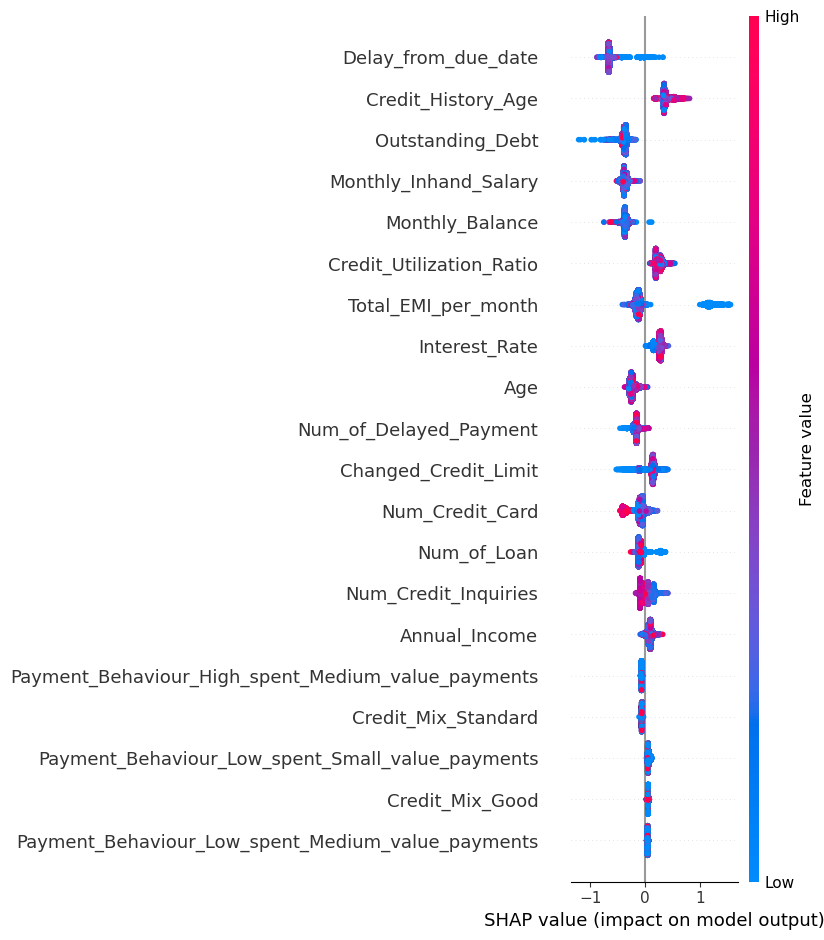

In [94]:
import shap

explainer = shap.Explainer(best_gb_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

Как мы видим на основание некоторых признаков можно явно определить один из двух классов. Также теперь для каждого отдельного объекта мы можем понять на основании каких признаков и значений модель приняля то или иное значение.